<a href="https://colab.research.google.com/github/solobala/TSML13/blob/main/TSML13_DZ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Элементарные методы анализа временных рядов»

Преподаватель: Даниил Корбут, Наталья Баданина
Задание

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

## Импорт библиотек и пользовательские функции

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.optimize import minimize, minimize_scalar
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from zipfile import ZipFile
from google.colab import drive
from google.colab import files
import os
from glob import glob
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Скользящее среднее

In [3]:
def moving_average(series: pd.Series, n: int) -> float:
    """Скользящее среднее
    ЗАЧЕМ ЗДЕСЬ НУЖНА КОНСТРУКЦИЯ isinstance()??? НЕ проще тип данных прописать во входных и выходных параметрах?
    аналогична type(), но выполняет проверку  с учетом иерархии наследования. Например,
    isinstance(True)== isinstance(2: int). А type() - более строгая реализация"""

    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [4]:
def predict_ma(series, N: int, n_pred: int) -> pd.Series:
    """Предсказание на основе скользящего среднего
    Новая серия строится на базе данной. В конец добавляется n_pred новых значений,
    которые считаются на основе N предыдущих измерений"""
    new_series = series.copy()  # датафрейм train
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series  # в конец добавили предсказания длиной test

In [5]:
def mse_ma(X: int):
    predictions = predict_ma(train, X, n_pred=len(test))
    error = mean_squared_error(predictions.iloc[train_n: train_n + test_n].astype(int), test.astype(int))
    return error

In [6]:
def ma_hyper(X0, Xmin, Xmax):
  # Подбор гиперпараметра - окна для скользящего среднего
  min_error = mse_ma(X0)
  x = X0
  for i in range(Xmin, Xmax):
    error = mse_ma(i)
    if error < min_error:
      min_error = error
      x = i
  # print(x, min_error)
  return x

In [7]:
def mse_cross_val_ma(X):
    split = TimeSeriesSplit(n_splits=5)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        predictions = predict_ma(train_split_ts, X, len(test_split_ts)).iloc[test_split_ts]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    # print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [8]:
def ma_cross_val_hyper(X0, Xmin, Xmax):
  # пОдбор гиперпараметра окна для скользящего среднего с помощью кросс-валидации
  min_error = mse_cross_val_ma(X0)
  x = X0
  for i in range(Xmin, Xmax):
    error = mse_cross_val_ma(i)
    if error < min_error:
      min_error = error
      x = i
  # print(x, min_error)
  return x, min_error

In [9]:
def ma(x0, X_min, X_max):
  print('Модель скользящего среднего (MA)')
  print('==================================================================================================================')
  print(f'ошибка модели с окном сглаживания {x0}: {mse_ma(x0)}')
  X = ma_hyper(x0, Xmin, Xmax)
  print(f'Подобранная величина окна сглаживания: {X}')
  print(f'ошибка модели с окном сглаживания {X}: {mse_ma(X)}')
  print(f'Ошибка кросс-валидации с окном {X}: {mse_cross_val_ma(X)}')
  X_opt, err = ma_cross_val_hyper(X0, Xmin, Xmax)
  print(f'Подобранная величина окна сглаживания как гиперпараметра кросс-валидации {X_opt}')
  err1 = mse_ma(X_opt)
  print(f'ошибка модели с окном сглаживания {X_opt}: {err1}')
  print(f'Ошибка кросс-валидации с окном {X_opt}: {err}')
  return err, err1

### Взвешенное скользящее среднее

In [10]:
def weighted_moving_average(series, weights):
    """Средневзвешенное скользящее среднее"""
    n = len(weights)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    # Что делает метод Rolling? передает n значений строки для подсчета средневзвешенной суммы с помощью lambda
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [11]:
def predict_wma(series, weights: list, n_pred: int):
    """Предсказывает n_pred наблюдений серии с использованием средневзвешенного скользящего среднего"""
    N = len(weights)
    n_pred = len(test)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    new_series = series.copy()
    for _ in range(n_pred):
        prediction = weighted_moving_average(new_series[-N:], weights)
        new_series = new_series.append(pd.Series(prediction.iloc[-1]), ignore_index=True)
    return pd.Series(new_series)

In [12]:
def plot_wma(series, weights):
  wma = weighted_moving_average(series, n, weights)
  with plt.style.context('bmh'):
      plt.figure(figsize=(14, 8))
      plt.plot(series, color='blue',label='original')
      plt.plot(wma, color='red', linewidth='2', label='FIB')
      plt.legend()

In [13]:
def mse_wma(X: list):
    predictions = predict_wma(train, X, n_pred=len(test))
    error = mean_squared_error(predictions.iloc[train_n:].astype(int), test.astype(int))
    return error

In [14]:
def mse_cross_val_wma(X):
    split = TimeSeriesSplit(n_splits=5)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        predictions = predict_wma(train_split_ts, weights, len(test_split_ts)).iloc[test_split_ts]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    # print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [15]:
def wma(weights):
  print('Модель взвешенного скользящего среднего (WMA)')
  print('==================================================================================================================')
  print(f'Ошибка модели при использовании начальных весов {weights}: {mse_wma(weights)}')
  opt = minimize(mse_wma, x0=weights, method='Nelder-Mead', bounds = ((0, 65), (0, 65), (0, 65),(0, 65), (0, 65), (0, 65), (0, 65)))
  weights, err = opt.x, opt.fun
  print(f'Подбор гиперпараметров - величин весов для взвешенного скользящего среднего {opt.x}')
  print(f'Ошибка модели при использовании подобранных весов {weights}: {err}')
  print(f'Ошибка кросс-валидации: {mse_cross_val_wma(weights)}')
  opt = minimize(mse_cross_val_wma, x0=weights, method='Nelder-Mead', bounds = ((0, 65), (0, 65), (0, 65),(0, 65), (0, 65), (0, 65), (0, 65)))
  weights, err = opt.x, opt.fun
  print(f'Веса, подобранные как гиперпараметр кросс-валидации: {weights}')
  err1 = mse_wma(weights)
  print(f'Ошибка модели при использовании весов, подобранных как гиперпеараметр при кросс-валидации: {err1}')
  print(f'Ошибка кросс-валидации при использовании подобранных весов: {err}')
  return err, err1

### Экспоненциальное скользящее среднее

In [16]:
def exponential_moving_average(series, alpha):
    """Экеспоненциальное скользящее среднее"""
    # результат - ряд в виде списка
    result = [series[0]] # нулевой элемент = нулевому элементу исходного ряда
    # для каждого последующего значения  в ряду
    for n in range(1, len(series)):
      # новое значение - сглаживающий фактор * на значение с тем же номером  в исходном ряду + (1 - сглаживающий фактор) * на предыдущее рассчитанное значение
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [17]:
def predict_ema(series, alpha, n_pred=None):
    """ПРедсказывает n_pred наблюдений серии с учетом к-та сглаживания """
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    # Если не нужно предсказывать будущие периоды, возвращает сглаженный ряд
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return series.append(pd.Series(predictions), ignore_index=True)[:-1], pd.Series(result)

In [18]:
def plot_ema(series, alpha):
    ema = exponential_moving_average(series, alpha)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(ema, color='red', linewidth='4', label='EMA')
        plt.title("alpha={}".format(alpha))
        plt.legend()

In [19]:
def mse_ema(X: float) -> float:
    alpha = X
    # ряд после экспоненциального сглаживания
    predictions, _  = predict_ema(train, alpha, len(test))
    error = mean_squared_error(predictions.iloc[-len(test):], test)
    return error

In [20]:
def mse_cross_val_ema(X):
  split = TimeSeriesSplit(n_splits=5)
  errors = []
  for train_split, test_split in split.split(train):
      train_split_ts = train.iloc[train_split]
      test_split_ts = train.iloc[test_split]
      predictions, old = predict_ema(train_split_ts, X, len(test_split_ts))
      predictions = predictions.iloc[-len(test_split_ts):]
      error = mean_squared_error(predictions, test_split_ts)
      errors.append(error)
  return np.mean(np.array(errors))
  # print(f'{np.mean(np.array(errors))}------------')

In [21]:
def ema(X):
  print('Модель экспоненциального скользящего среднего (EMA)')
  print('==================================================================================================================')
  print(f'Ошибка модели при использовании произвольного гиперпараметра alpha {X}: {mse_ema(X)}')
  print(f'Ошибка кросс-валидации при использовании произвольного alpha={X}: {mse_cross_val_ema(X)}')
  opt = minimize_scalar(mse_ema,  bounds = (0, 1))
  alpha, err = opt.x, opt.fun
  print(f'Подбор гиперпараметра alpha :{opt.x}')
  print(f'Ошибка модели при использовании alpha= {alpha}: {err}')
  print(f'Ошибка кросс-валидации: {mse_cross_val_ema(alpha)}')
  opt = minimize_scalar(mse_cross_val_ema, bounds = (0, 1))
  alpha, err = opt.x, opt.fun
  print(f'Alpha, подобранныЙ как гиперпараметр кросс-валидации: {alpha}')
  err1 = mse_ema(alpha)
  print(f'Ошибка модели при использовании alpha={alpha}: {err1}')
  print(f'Ошибка кросс-валидации при использовании alpha={alpha}: {err}')
  return err, err1

### Двойное экспоненциальное скользящее среднее

In [22]:
def double_ema(series, alpha, beta):
    """Двойное экспоненциальное сглаживание"""
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [23]:
def predict_dema(series, alpha, beta, n_preds):
    """Предсказывает n_pred наблюдений серии с использованием
    двойного экспоненциального
    скользящего среднего и к-тов сглаживания alpha и beta"""
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [24]:
def mse_dema(X: tuple[float, float]) -> float:
    alpha, beta = X
    # ряд после двойного сглаживания
    predictions, _  = predict_dema(train, alpha, beta, len(test))
    error = mean_squared_error(predictions.iloc[train_n: train_n + test_n], test)
    return error

In [25]:
def mse_cross_val_dema(X):

  split = TimeSeriesSplit(n_splits=5)
  errors = []
  for train_split, test_split in split.split(train):
      train_split_ts = train.iloc[train_split]
      test_split_ts = train.iloc[test_split]
      predictions, old = predict_dema(train_split_ts, X[0], X[1],len(test_split_ts))
      predictions = predictions.iloc[-len(test_split_ts):]
      error = mean_squared_error(predictions, test_split_ts)
      errors.append(error)
  return np.mean(np.array(errors))

In [26]:
def dema(X):
  print('Модель двойного экспоненциального сглаживания (DEMA)')
  print('==================================================================================================================')
  print(f'Ошибка модели при использовании произвольых гиперпараметров alpha {X[0]} и beta {X[1]}: {mse_dema(X)}')
  print(f'Ошибка кросс-валидации при использовании произвольых гиперпараметров alpha {X[0]} и beta {X[1]}: {mse_cross_val_dema(X)}')
  opt = minimize(mse_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 0.9), (0, 0.9)))
  alpha, beta, err = opt.x[0], opt.x[1], opt.fun
  print(f'Оптимальные гиперпараметры alpha={opt.x[0]} и beta={opt.x[1]}')
  print(f'Ошибка модели при использовании alpha= {alpha} и beta={beta}: {err}')
  print(f'Ошибка кросс-валидации: {mse_cross_val_dema([alpha, beta])}')
  opt = minimize(mse_cross_val_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 0.9), (0, 0.9)))
  alpha, beta, err = opt.x[0], opt.x[1], opt.fun
  print(f'Оптимальные гиперпараметры кросс-валидации: alpha={opt.x[0]} и beta={opt.x[1]}')
  err1 = mse_dema([alpha, beta])
  print(f'Ошибка модели при использовании alpha= {alpha} и beta={beta}: {err1}')
  print(f'Ошибка кросс-валидации при использовании alpha={alpha} и beta={beta}: {err}')
  return err, err1

### Тройное экспоненциальное скользящее среднее (метод Хольта-Винтерса)

In [27]:
def initial_trend(series: pd.Series, season_len: int):
    """Определяет начальный тренд путем вычитания сезонности"""
    sum = 0.0
    for i in range(season_len):
      k = i + season_len
      if k <= len(series):
        sum += float(series[k] - series[i]) / season_len
    return sum / season_len

In [28]:
def initial_seasonal_components(series, slen):
    """slen - список сезонностей"""
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [29]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds=None):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth - last_smooth) + (1-beta)*trend
            seasonals[i % slen] = gamma*(val - smooth) + (1 - gamma) * seasonals[i % slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [30]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [31]:
def mse_tema(X: tuple[float, float, float], season=12) -> float:
    alpha, beta, gamma = X
    # ряд после тройного сглаживания
    result = triple_exponential_smoothing(train, season, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [32]:
def mse_cross_val_tema(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [33]:
def tema(X):
  print('Модель тройного экспоненциального сглаживания (TEMA)')
  print('==================================================================================================================')
  # print(f'Ошибка модели при использовании произвольых гиперпараметров alpha={X[0]}, beta={X[1]}, gamma={X[2]}: {mse_tema(X)}')
  # print(f'Ошибка кросс-валидации при использовании произвольых гиперпараметров alpha {X[0]}, beta={X[1]}, gamma={X[2]}:: {mse_cross_val_tema(X)}')
  opt = minimize(mse_tema, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 0.9), (0, 0.9), (0, 0.9)))
  alpha, beta, gamma,  err = opt.x[0], opt.x[1], opt.x[2], opt.fun
  print(f'Оптимальные гиперпараметры alpha={opt.x[0]}, beta={opt.x[1]}, gamma={opt.x[2]}')
  print(f'Ошибка модели при использовании alpha={alpha}, beta={beta}, gamma={gamma}: {err}')
  print(f'Ошибка кросс-валидации: {mse_cross_val_tema([alpha, beta, gamma])}')
  opt = minimize(mse_cross_val_tema, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 0.9), (0, 0.9), (0, 0.9)))
  alpha, beta, gamma, err = opt.x[0], opt.x[1], opt.x[2], opt.fun
  print(f'Оптимальные гиперпараметры кросс-валидации: alpha={opt.x[0]}, beta={opt.x[1]}, gamma={opt.x[2]}')
  err1 = mse_tema([alpha, beta, gamma])
  print(f'Ошибка модели при использовании alpha={alpha}, beta={beta}, gamma={gamma}: {err1}')
  print(f'Ошибка кросс-валидации при использовании alpha={alpha}, beta={beta}, gamma={gamma}: {err}')
  return err, err1

## 1. Загрузка данных

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
ROOT = '/content/drive/MyDrive/TSML13_DZ1'
SERIES = Path(ROOT, 'Series')

[ДЗ №1](https://colab.research.google.com/drive/1E04F_Sh6j6YdEYVurDfdB4sx4bU1r8_s#scrollTo=cnC9WiaNlF9W)

In [36]:
# Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный
stat_series = pd.read_csv('/content/drive/MyDrive/TSML13_DZ1/Series/daily-total-female-births-in-cal.csv')
unstat_series = pd.read_csv('/content/drive/MyDrive/TSML13_DZ1/Series/international-airline-passengers.csv')
# stat_series = pd.read_csv('/content/drive/MyDrive/TSML13_DZ1/Series/daily-total-female-births-in-cal.csv', index_col = 'Date', parse_dates = True)
# unstat_series = pd.read_csv('/content/drive/MyDrive/TSML13_DZ1/Series/international-airline-passengers.csv', index_col = 'Month', parse_dates = True)

примечание:
1. stat_series - наиболее стационарный ряд из представленных в дз 1
2. unstat_series - самый нестационарный ряд из дз 1, в нем присутствуют и нестационарность тренда, и сезонность. Здесб мы его берем как есть, без приведения к стационарности, но вообще это неправильно, поскольку модели, подобранные на таком ряде, будут иметь низкую предсказаьтельную способность ( грубо говоря, врать будут!)

## 2. Приблизьте оба варианта моделями класса MA

К классу моделей МА (mean_average model) относятся модели стационарных рядов с использованием:
* скользящего среднего,
* взвешенного скользящего среднего,  
* экспоненциального сглаживания,
* двойного экспоненциального сглаживания (учитывает нестационарность тренда),
* тройного экспоненциального скользящего среднего (учитывает сезонность)

MA - модели - это частный случай ARMA: MA(q) = ARMA(0,q), где q - порядок лага.
Ряд  "забыввает" прошлые значения с лагами > порядка q

### Модели для стационарного временного ряда

#### Разбиение ряда на train и test

In [37]:
train_n = int(len(stat_series)*0.8) # для обучающего датасета возьмем 80% записей от начала, для тестового - остальные
test_n = len(stat_series) - train_n
train, test = stat_series[:train_n]['Count'],  stat_series[train_n:]['Count']
len(stat_series), len(train), len(test)

(365, 292, 73)

#### Выявление тренда методом скользящего среднего

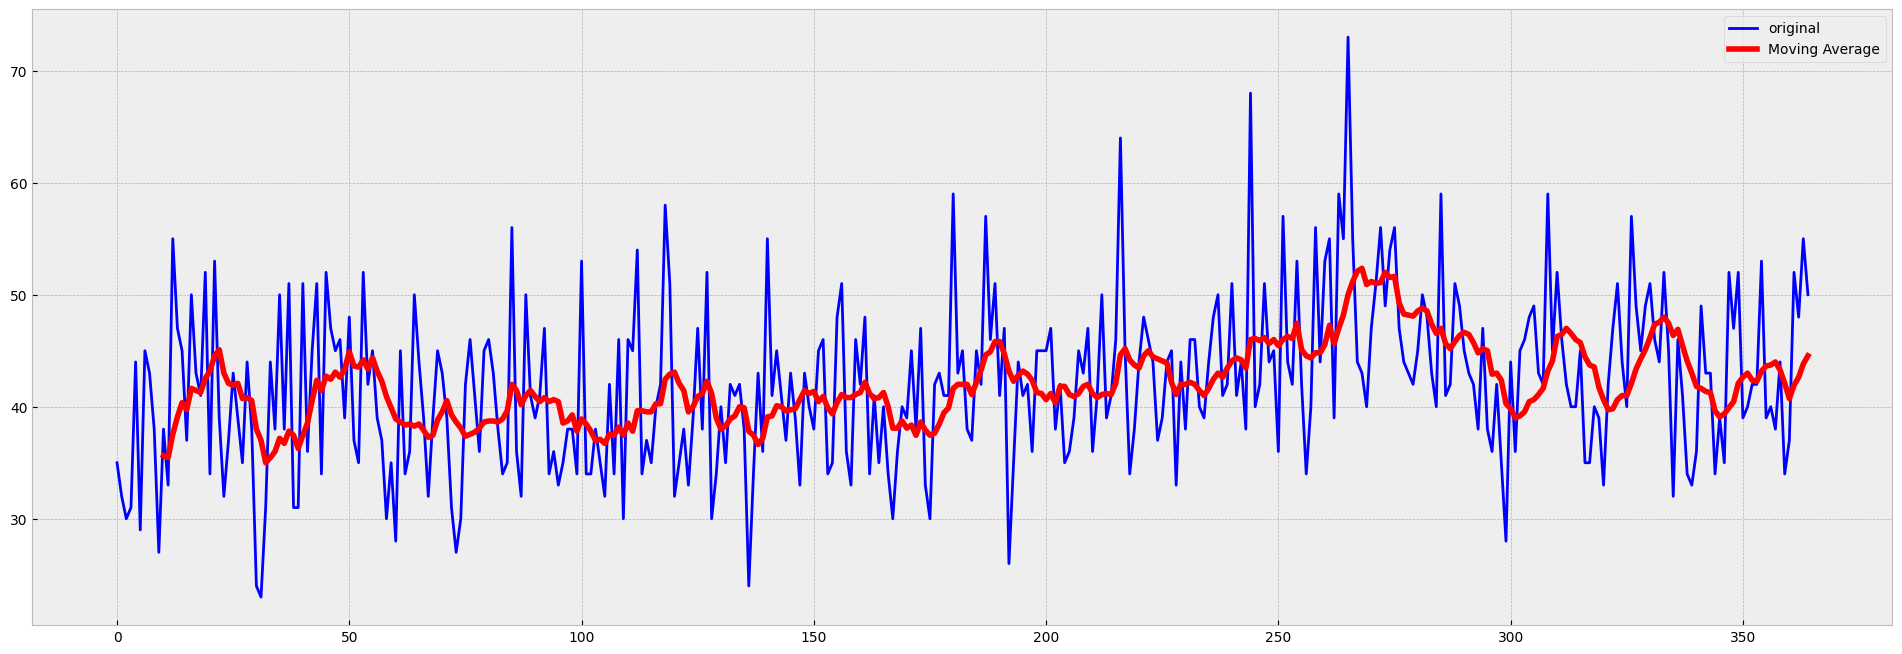

In [38]:
# Метод скользящего среднего помогает выявить тренд и проверить, есть ли в нем изменения или он стационарен
ts = stat_series['Count']
ser = moving_average(ts, 11)
with plt.style.context('bmh'):
    plt.figure(figsize=(24, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Применим поочередно модели скользящего среднего, взвешенного скользящего среднего, экспоненциального скользящего среднего и двойного экспоненциального скользящего среднего и выберем лучшую. Метод Хольта-Винтерса применятся не будет, т.к в ряде не обнаружена сезонность. При выборе лучшей модели будем использовать mse, определенную в ходе кросс-валидации.

In [39]:
results_cv = dict()
results = dict()

#### Модель скользящего среднего (МА)

In [40]:
X0 = 2
Xmin = 1
Xmax = 60
results_cv['ma'] , results['ma'] = ma(X0, Xmin, Xmax)


Модель скользящего среднего (MA)
ошибка модели с окном сглаживания 2: 41.3013698630137
Подобранная величина окна сглаживания: 1
ошибка модели с окном сглаживания 1: 41.26027397260274
Ошибка кросс-валидации с окном 1: 93.60416666666667
Подобранная величина окна сглаживания как гиперпараметра кросс-валидации 11
ошибка модели с окном сглаживания 11: 49.76712328767123
Ошибка кросс-валидации с окном 11: 92.00156977807058


#### Модель взвешенного скользящего среднего

In [41]:
weights = [1,32,2,3,5,8,6]
results_cv['wma'], results['wma'] = wma(weights)

Модель взвешенного скользящего среднего (WMA)
Ошибка модели при использовании начальных весов [1, 32, 2, 3, 5, 8, 6]: 44.917808219178085
Подбор гиперпараметров - величин весов для взвешенного скользящего среднего [ 1.  33.6  2.   3.   5.   8.   6. ]
Ошибка модели при использовании подобранных весов [ 1.  33.6  2.   3.   5.   8.   6. ]: 44.49315068493151
Ошибка кросс-валидации: 91.78142850148049
Веса, подобранные как гиперпараметр кросс-валидации: [ 1.  33.6  2.   3.   5.   8.   6. ]
Ошибка модели при использовании весов, подобранных как гиперпеараметр при кросс-валидации: 44.49315068493151
Ошибка кросс-валидации при использовании подобранных весов: 91.78142850148049


#### Модель экспоненциального сглаживания

In [42]:
alpha = 0.6
results_cv['ema'], results['ema'] = ema(alpha)

Модель экспоненциального скользящего среднего (EMA)
Ошибка модели при использовании произвольного гиперпараметра alpha 0.6: 45.904355614498826
Ошибка кросс-валидации при использовании произвольного alpha=0.6: 60.91675633850275
Подбор гиперпараметра alpha :0.991473306544406
Ошибка модели при использовании alpha= 0.991473306544406: 41.25909103454129
Ошибка кросс-валидации: 84.14870625976377
Alpha, подобранныЙ как гиперпараметр кросс-валидации: 0.05009879516157982
Ошибка модели при использовании alpha=0.05009879516157982: 58.794593384906925
Ошибка кросс-валидации при использовании alpha=0.05009879516157982: 50.77072854419858


#### Модель двойного экспоненциального сглаживания

In [43]:
alpha = 0.6
beta = 0.2
results_cv['dema'], results['dema'] = dema([alpha, beta])

Модель двойного экспоненциального сглаживания (DEMA)
Ошибка модели при использовании произвольых гиперпараметров alpha 0.6 и beta 0.2: 414.0897084791521
Ошибка кросс-валидации при использовании произвольых гиперпараметров alpha 0.6 и beta 0.2: 647.6355971067721
Оптимальные гиперпараметры alpha=0.581522970370607 и beta=0.01845560893931768
Ошибка модели при использовании alpha= 0.581522970370607 и beta=0.01845560893931768: 42.59279707172544
Ошибка кросс-валидации: 373.26858078648695
Оптимальные гиперпараметры кросс-валидации: alpha=0.0817073167332915 и beta=0.042711750913769914
Ошибка модели при использовании alpha= 0.0817073167332915 и beta=0.042711750913769914: 61.140238459878496
Ошибка кросс-валидации при использовании alpha=0.0817073167332915 и beta=0.042711750913769914: 48.88558104562302


In [44]:
print(results_cv)

{'ma': 92.00156977807058, 'wma': 91.78142850148049, 'ema': 50.77072854419858, 'dema': 48.88558104562302}


In [45]:
print(results)

{'ma': 49.76712328767123, 'wma': 44.49315068493151, 'ema': 58.794593384906925, 'dema': 61.140238459878496}


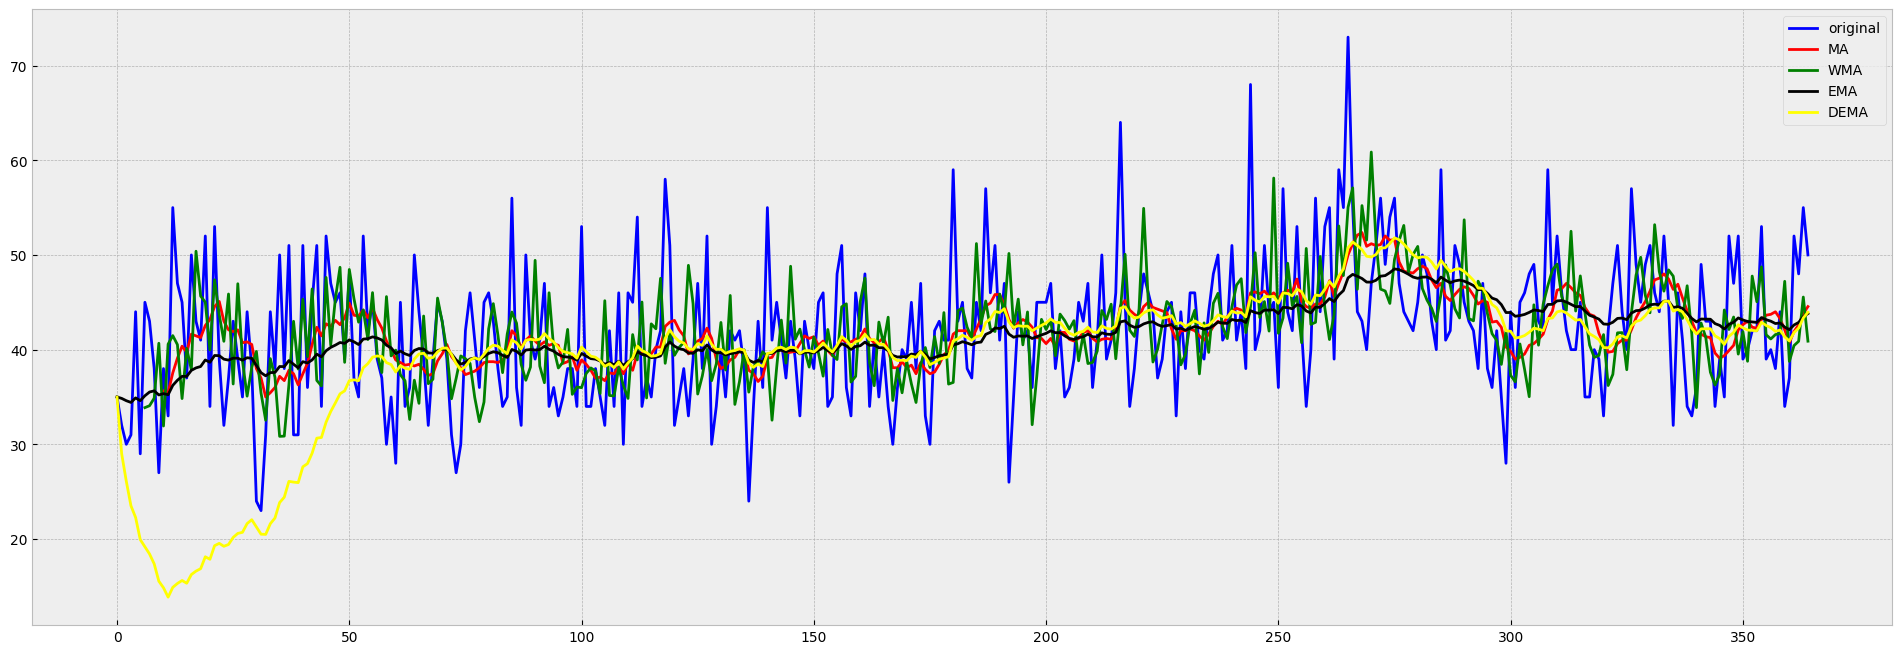

In [46]:
# original, ma, wma, ema и dema на всем временном ряде
ma_ = moving_average(ts, 11)
wma_ = weighted_moving_average(ts,  [ 1.,  33.6,  2.,   3.,   5.,   8.,   6. ])
ema_ = exponential_moving_average(ts, 0.05009879516157982)
dema_ = double_ema(ts, 0.0817073167332915, 0.042711750913769914 )

with plt.style.context('bmh'):
    plt.figure(figsize=(24, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ma_, color='red', linewidth='2', label='MA')
    plt.plot(wma_, color='green', linewidth='2', label='WMA')
    plt.plot(ema_, color='black', linewidth='2', label='EMA')
    plt.plot(dema_, color='yellow', linewidth='2', label='DEMA')
    plt.legend()

Прогнозы на тесте, рассчитанные различными моделями

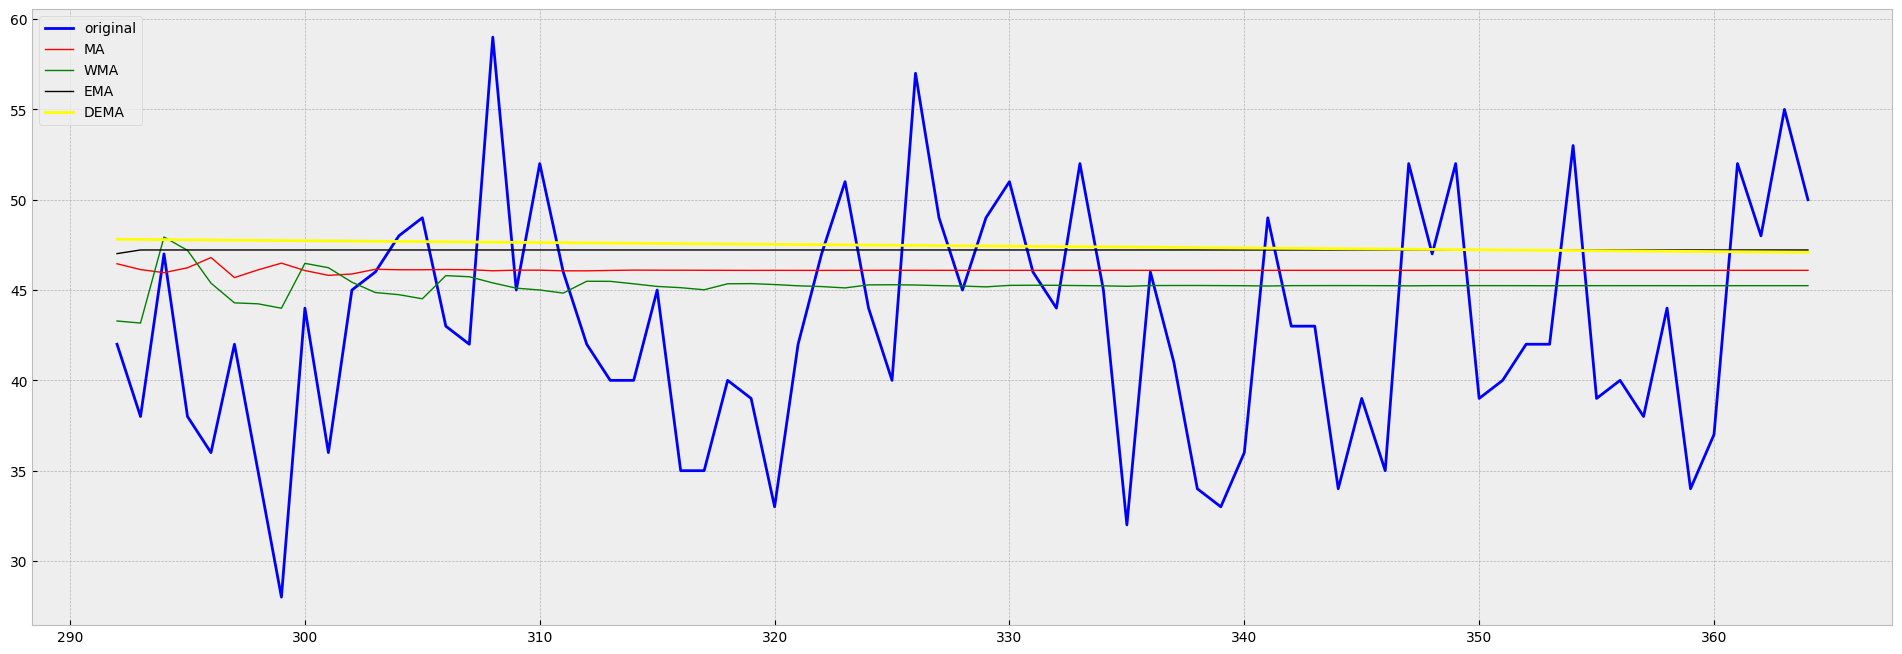

In [47]:
wma_ = predict_wma(train, [ 1.,  33.6,  2.,   3.,   5.,   8.,   6. ], len(test))
ma_ = predict_ma(train, 11, len(test))
ema_, _ = predict_ema(train, 0.05009879516157982, len(test))
dema_, _ = predict_dema(train, 0.0817073167332915,0.042711750913769914, len(test))

with plt.style.context('bmh'):
    plt.figure(figsize=(24, 8))
    plt.plot(stat_series.loc[train_n:train_n+test_n]['Count'], color='blue',label='original')
    plt.plot(ma_.loc[train_n:train_n+test_n], color='red', linewidth='1', label='MA')
    plt.plot(wma_.loc[train_n:train_n+test_n], color='green', linewidth='1', label='WMA')
    plt.plot(ema_.loc[train_n:train_n+test_n], color='black', linewidth='1', label='EMA')
    plt.plot(dema_.loc[train_n:train_n+test_n], color='yellow', linewidth='2', label='DEMA')
    plt.legend()

Вывод: Если опираться на величину mse, полученную при кросс-валидации каждой из моделей с оптимальными гиперпараметрами, то лучшей моделью для данного стационарного ряда является DEMA. В то же время, если ориентироваться на визуализацию и величину mse на тесте, то лучшей моделью выглядит wma

### Модели для нестационарного временного ряда

#### Разбиение ряда на train и test

In [48]:
train_n = int(len(unstat_series)*0.8) # для обучающего датасета возьмем 80% записей от начала, для тестового - остальные
test_n = len(unstat_series) - train_n
train, test = unstat_series[:train_n]['Count'],  unstat_series[train_n:]['Count']
len(unstat_series), len(train), len(test)

(144, 115, 29)

#### Выявление тренда методом скользящего среднего

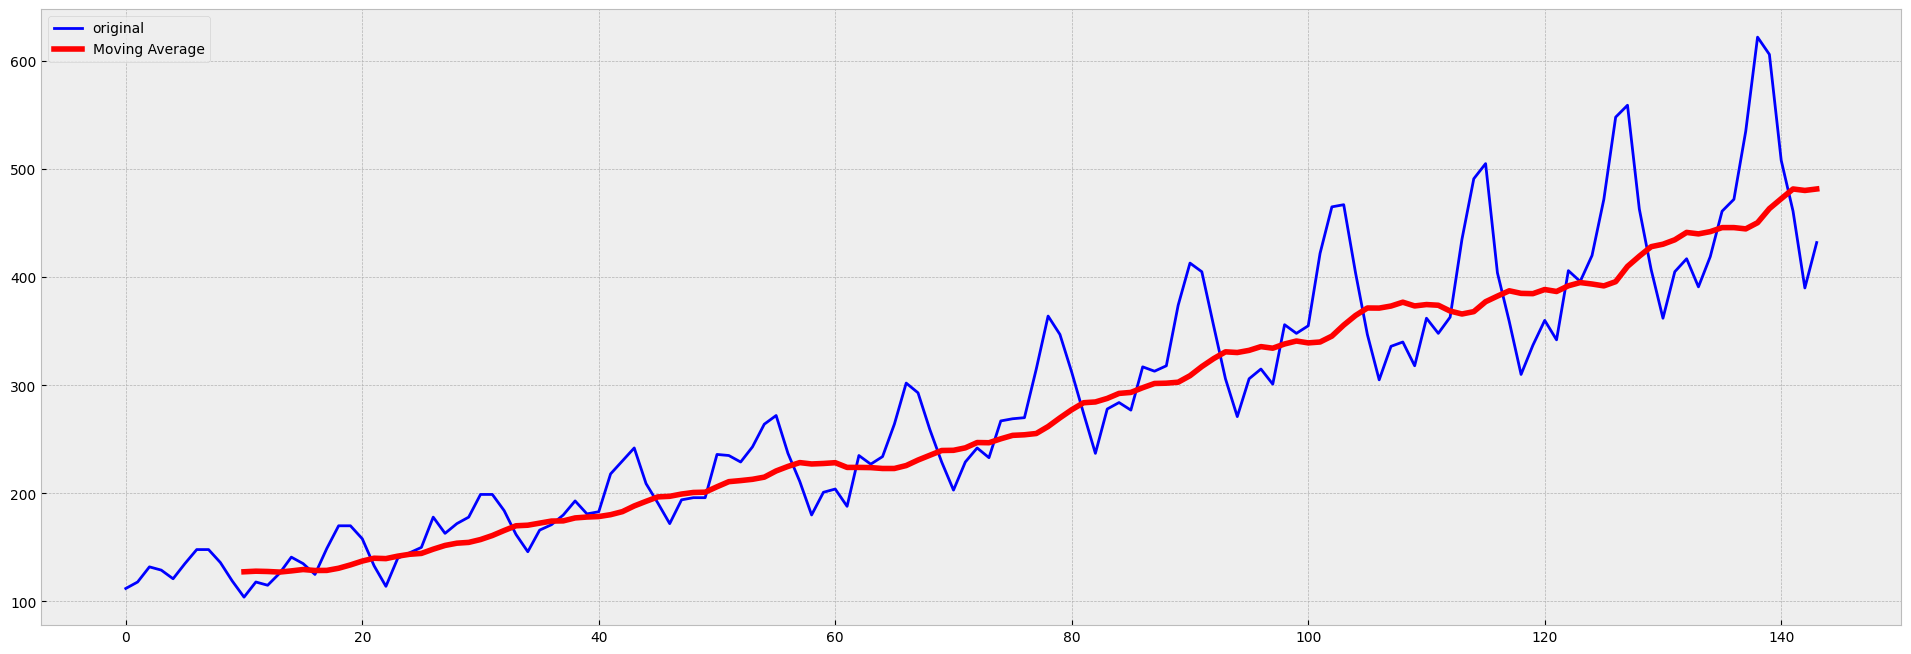

In [49]:
# Метод скользящего среднего помогает выявить тренд и проверить, есть ли в нем изменения или он стационарен
ts = unstat_series['Count']
ser = moving_average(ts, 11)
with plt.style.context('bmh'):
    plt.figure(figsize=(24, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Выявлен сильный восходящий тренд

#### Метод Хольта-Винтерса

Применим метод Хольта-Винтерса, т.к в ряде  обнаружена сезонность. Модели ema и dema использовать не будем, т.к  врассматриваемом ряде была выявлена сезонность. При выборе лучшей модели будем использовать mse, определенную в ходе кросс-валидации.

In [50]:
results_cv = dict()
results = dict()

In [51]:
results_cv['tema'], results['tema'] = tema([0, 0, 0])

Модель тройного экспоненциального сглаживания (TEMA)
Оптимальные гиперпараметры alpha=0.0028828069179832297, beta=0.9, gamma=0.7230252178472933
Ошибка модели при использовании alpha=0.0028828069179832297, beta=0.9, gamma=0.7230252178472933: 545.4928031756758
516.255564264511------------
Ошибка кросс-валидации: 516.255564264511
9600.769178206918------------
9493.44449623247------------
9600.769178206874------------
9591.796736573504------------
9522.607974735167------------
9471.86394518913------------
9408.470269313475------------
9359.107275951765------------
9245.487494605344------------
9244.956183129818------------
9110.921781811265------------
9022.744295452738------------
8800.335287362743------------
8709.238214936357------------
8387.49568628202------------
8314.954950788442------------
7907.861056514033------------
7682.663596960411------------
7091.822595126353------------
6913.462098331285------------
6203.303065069591------------
5980.3353063045215------------
5188.91996837

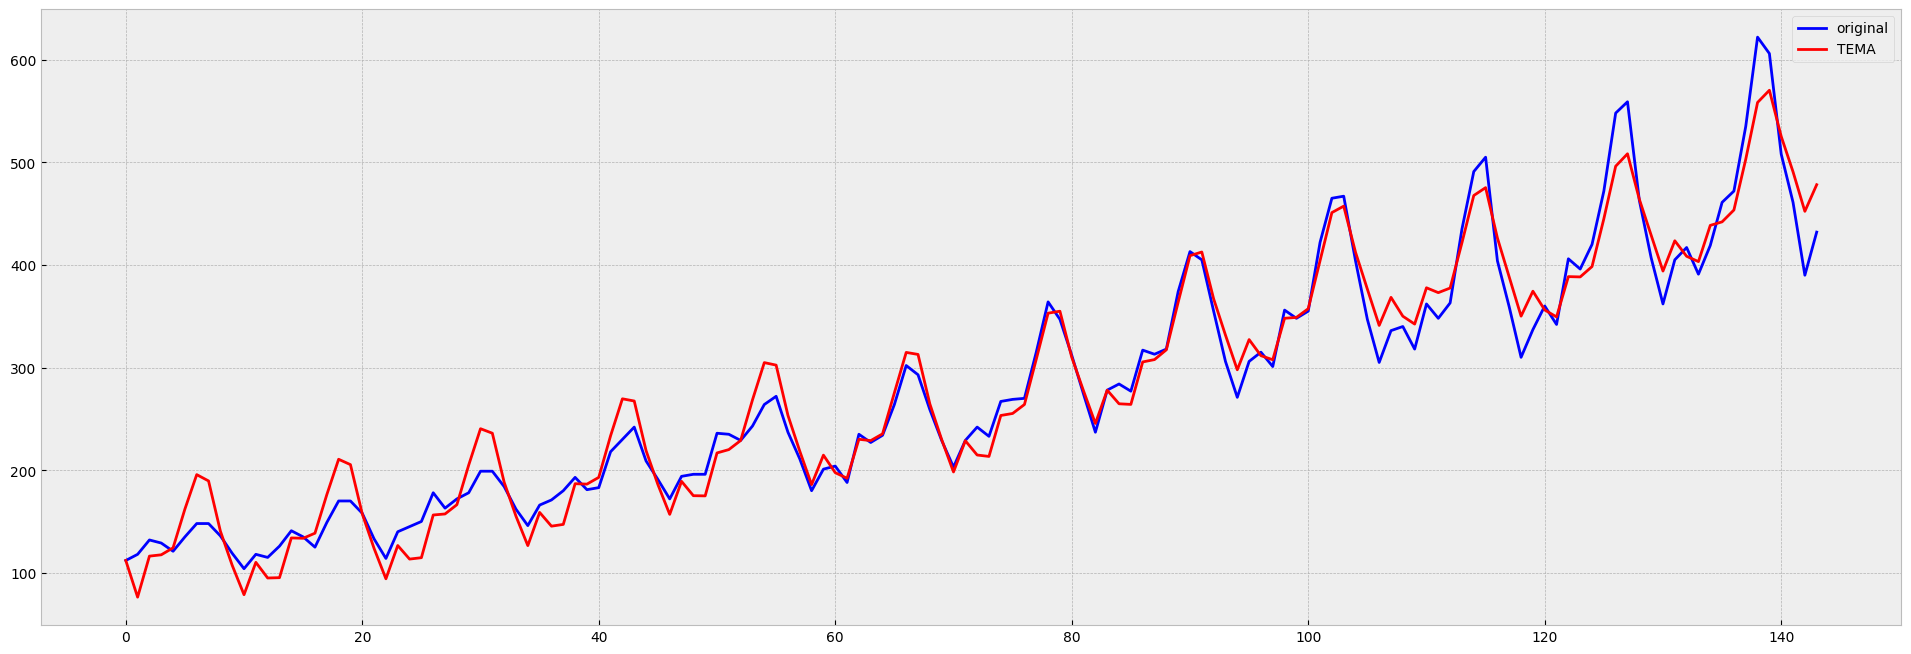

In [52]:
# original, tema на всем временном ряде
alpha = 0.134264466587864
beta = 0.10039560273808358
gamma=0.0
tema_ = triple_exponential_smoothing(ts, 12, alpha, beta, gamma, len(test))[:len(ts)]
with plt.style.context('bmh'):
    plt.figure(figsize=(24, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(tema_, color='red', linewidth='2', label='TEMA')

    plt.legend()

Прогнозы на тесте

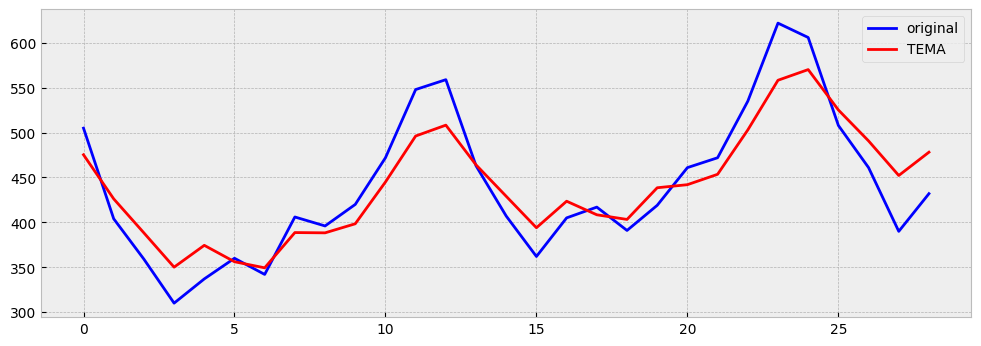

In [53]:
tema_ = triple_exponential_smoothing(ts, 12, alpha, beta, gamma, len(test))

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(ts.loc[train_n:train_n+test_n].tolist(), color='blue',label='original')

    plt.plot(tema_[train_n: train_n + test_n], color='red', linewidth='2', label='TEMA')
    plt.legend()

видно, что графики не очень хорошо совпадают, хотя характер возрастания и убывания соблюдается. ПРичина - в том, что для рассмотрения был взят нестационарный ряд "как есть", а следовало предварительно выполнить преобразования по приведению его к стационарности.

#### Приведение к стационарности

In [54]:
ts = unstat_series['Count']
ts = ts.apply(lambda x: boxcox(x,0)) # Применяем преобразование Boxcox


#### Разбиение ряда на train и test

In [55]:
train_n = int(len(ts)*0.8) # для обучающего датасета возьмем 80% записей от начала, для тестового - остальные
test_n = len(ts) - train_n
train, test = ts[:train_n],  ts[train_n:]
len(ts), len(train), len(test)

(144, 115, 29)

#### Метод Хольта-Винтерса

In [56]:
results_cv['stat_tema'], results['stat_tema'] = tema([0, 0, 0])


Модель тройного экспоненциального сглаживания (TEMA)
Оптимальные гиперпараметры alpha=9.361107465192537e-05, beta=0.4747966750412103, gamma=0.40129380283605204
Ошибка модели при использовании alpha=9.361107465192537e-05, beta=0.4747966750412103, gamma=0.40129380283605204: 0.001140586201204603
0.015383360284757572------------
Ошибка кросс-валидации: 0.015383360284757572
0.09098112552710062------------
0.08938919154427079------------
0.09098112552710062------------
0.09084595318213784------------
0.08982675746140074------------
0.08906830007789078------------
0.0881325327789463------------
0.08742398360409646------------
0.08577996838101017------------
0.08573821652369194------------
0.08379067166585343------------
0.08255056925110937------------
0.07940289067186025------------
0.07815007509532212------------
0.07375131835591625------------
0.07264773360408212------------
0.06713904337556535------------
0.0644001352416234------------
0.057083745169102675------------
0.0548290578913837---

После определения к-тов модели необходимо выполнить обратные преобразования для элементов ряда

In [57]:
ts = ts.apply(lambda x: inv_boxcox(x,0))

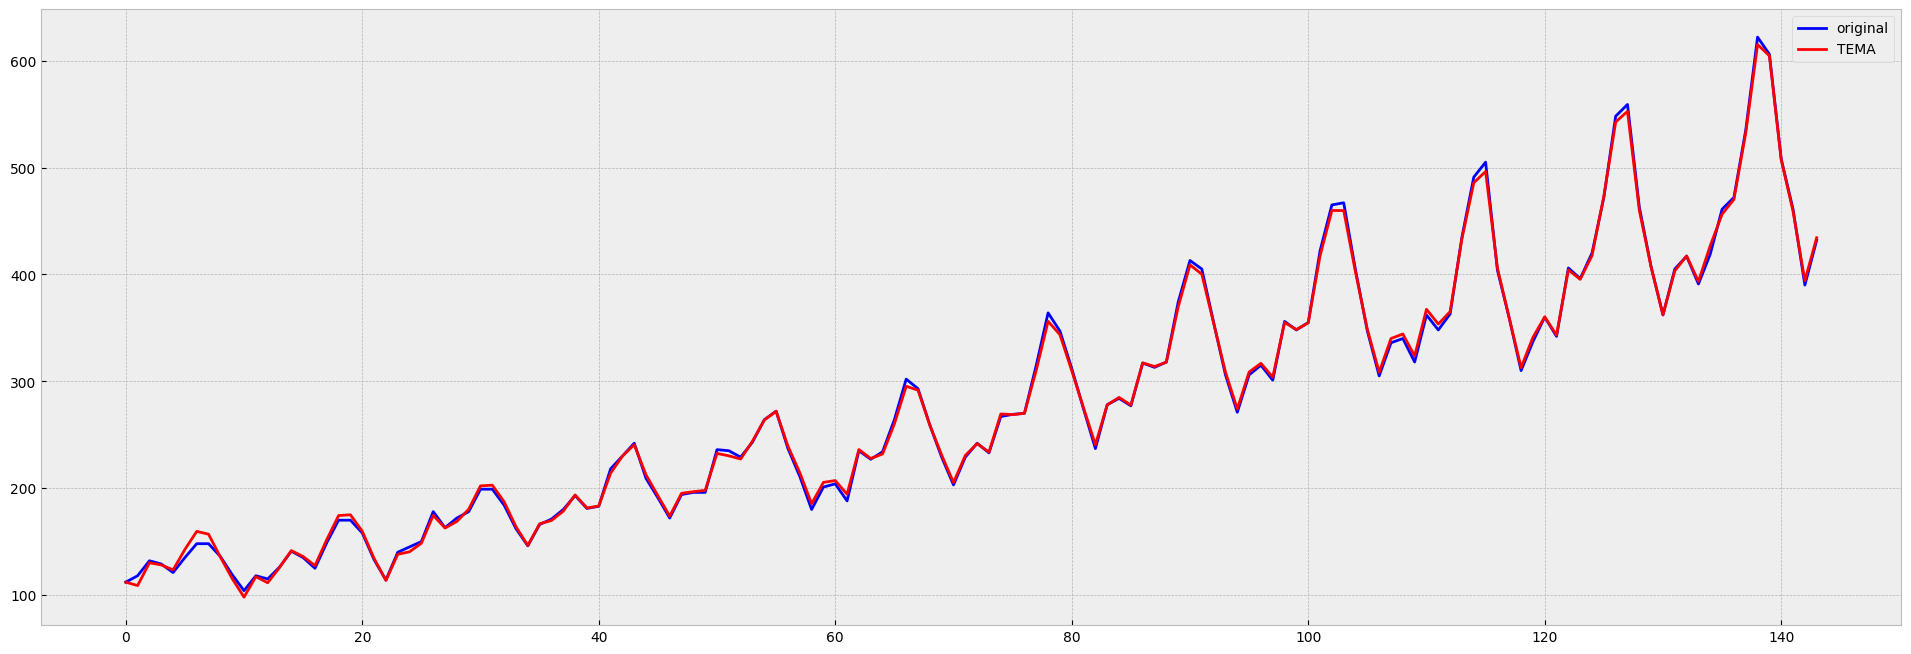

In [58]:
alpha=0.2691942053177102
beta=0.0
gamma=0.7206043050221724
tema_ = triple_exponential_smoothing(ts, 12, alpha, beta, gamma, len(test))[:len(ts)]
with plt.style.context('bmh'):
    plt.figure(figsize=(24, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(tema_, color='red', linewidth='2', label='TEMA')

    plt.legend()

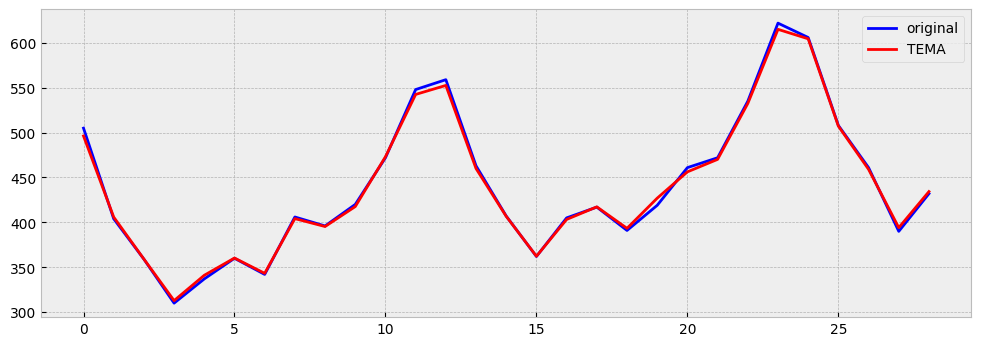

In [59]:

tema_ = triple_exponential_smoothing(ts, 12, alpha, beta, gamma, len(test))

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(ts.loc[train_n:train_n+test_n].tolist(), color='blue',label='original')

    plt.plot(tema_[train_n: train_n + test_n], color='red', linewidth='2', label='TEMA')
    plt.legend()

Исходный ряд практически совпал с моделью! Поэтому основной вывод: прежде чем начать моделировать, необходимо выполнить рприведение ряда к стационарности